# Model Training and evaluation

In this notebook, we will train and evaluate six different models, categorized into linear/quadratic methods and non-linear methods.

### Linear Methods
The linear models we will train are:
1. **Naive Bayes**:
   - Multinomial Naive Bayes
   - Gaussian Naive Bayes
   - Bernoulli Naive Bayes
2. **Logistic Regression**
3. **K-Nearest Neighbors (KNN)**

### Quadratic and Non-Linear Methods
The non-linear models we will train are:
1. **Random Forests**
2. **Support Vector Machines (SVM)** with an RBF kernel
3. **Gradient Boosting**

### Objectives
For each model, we will:
1. Perform hyperparameter tuning to identify the optimal configuration.
2. Analyze the importance assigned to each feature (when applicable).
3. Compare and summarize the performance differences between these models.

This analysis will help us understand the strengths and weaknesses of each approach and how well they perform on the given dataset.


In [1]:
# !pip3 install -r requirements.txt # install dependencies

In [2]:
# Uncomment to upgrade packages
# !pip3 install pandas --upgrade --quiet
# !pip3 install numpy --upgrade --quiet
# !pip3 install scipy  --upgrade --quiet
# !pip3 install statsmodels  --upgrade --quietq
# !pip3 install seaborn  --upgrade --quiet
# !pip3 install matplotlib  --upgrade --quiet
# !pip3 install scikit-learn  --upgrade
# !pip install scikit-optimize  --quiet
!pip install apafib --upgrade  --quiet
!pip install scikit-optimize --quiet
!pip install dtreeviz --quiet
!pip install pmlb --upgrade  --quiet

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn import set_config

from sklearn.metrics import  precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB


from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve
from sklearn.inspection import permutation_importance

from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, PrecisionRecallDisplay,
                             RocCurveDisplay, accuracy_score,
                             classification_report, f1_score, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.naive_bayes import GaussianNB
from skopt import BayesSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.svm import SVC

np.int = int # fix for skopt
import warnings

import dtreeviz
from apafib import load_attrition
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

### Function for data resampling

In [4]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'Cross-val acc'] = clf.best_score_
    else:
        df.loc[nclf,'Cross-val acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_dfLinear = pd.DataFrame()
results_dfNonLinear = pd.DataFrame()

### Parameters for Model Training

- **`cv = 10`**: Number of cross-validation folds to ensure robust evaluation.  
- **`niter = 15`**: Number of iterations for hyperparameter search to balance exploration and computation.  
These values provide reliable results without excessive computational cost.


In [5]:
cv=10
niter = 15

### Loading the preprocessed data

In this notebook, we will skip the preprocessing step, as it was already performed in the **DataPreparation** notebook. At the end of that process, the preprocessed and split data were saved as CSV files. Here, we will simply load those files to proceed with model training.


In [6]:
files = {
    "X_train": "X_train.csv",
    "y_train": "y_train.csv",
    "X_test": "X_test.csv",
    "y_test": "y_test.csv",
}

data = {}

# Load the data
for key, filename in files.items():
    filepath = os.path.join('data/', filename)
    try:
        data[key] = pd.read_csv(filepath)
        print(f"{key} loaded successfully. Shape: {data[key].shape}")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{filepath}' is empty.")
    except Exception as e:
        print(f"Error loading '{filepath}': {e}")

X_train = data.get("X_train")
y_train = data.get("y_train")
X_test = data.get("X_test")
y_test = data.get("y_test")

if any(df is None for df in [X_train, y_train, X_test, y_test]):
    print("Some files could not be loaded. Please check the errors above.")
else:
    print("All files loaded successfully.")

X_train loaded successfully. Shape: (7000, 29)
y_train loaded successfully. Shape: (7000, 1)
X_test loaded successfully. Shape: (3000, 29)
y_test loaded successfully. Shape: (3000, 1)
All files loaded successfully.


The class names we are going to classify are:

In [7]:
target_names = [str(v) for v in sorted(y_train['IncidentGrade'].unique())]
print(f"Target names: {target_names}")

Target names: ['BenignPositive', 'FalsePositive', 'TruePositive']


In [8]:
# Reshape y_train and y_test to be 1-dimensional arrays if they are DataFrames
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.values.ravel()
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values.ravel()

### Linear / Quadratic Methods

### Naïve Bayes

We have chosen Naïve Bayes because it is typically very efficient in terms of computation time and does not require tuning hyperparameters. Although the assumption of feature independence is not fully met (as seen in the data preparation step), we still want to evaluate its performance. Even in cases where features are not entirely independent, Naïve Bayes can still provide reasonable results, making it a valuable benchmark for this task.


In [9]:
multinomialNB = MultinomialNB()
multinomialNB.best_score_ = np.mean(cross_val_score(multinomialNB,X_test,y_test,cv=cv))
print(multinomialNB.best_score_)

0.5519999999999999


In [10]:
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train,y_train,cv=10))
print(gnb.best_score_)

0.41500000000000004


In [11]:
bnb = BernoulliNB()
bnb.best_score_ = np.mean(cross_val_score(bnb,X_train,y_train,cv=10))
print(bnb.best_score_)


0.5808571428571427


- **Multinomial**: 0.552
- **Gaussian**: 0.4150
- **Bernoulli**: 0.5809

These scores represent the average performance of each Naïve Bayes variant based on cross-validation. The Bernoulli model performed the best, followed by Multinomial, and Gaussian had the lowest score.


In [12]:
mnb_model = MultinomialNB().fit(X_train, y_train)
gnb_model = GaussianNB().fit(X_train, y_train)
bnb_model = BernoulliNB().fit(X_train, y_train)

In [13]:
print('MultinomialNB')
print(classification_report(y_test, mnb_model.predict(X_test), target_names=target_names))
results_dfLinear = save_results(mnb_model, X_test, y_test, 'MNB', results_dfLinear)
print('GaussianNB')
print(classification_report(y_test, gnb_model.predict(X_test), target_names=target_names))
results_dfLinear = save_results(gnb_model, X_test, y_test, 'GNB', results_dfLinear)
print('BernoulliNB')
print(classification_report(y_test, bnb_model.predict(X_test), target_names=target_names))


MultinomialNB
                precision    recall  f1-score   support

BenignPositive       0.50      0.90      0.64      1268
 FalsePositive       0.00      0.00      0.00       653
  TruePositive       0.63      0.41      0.50      1079

      accuracy                           0.53      3000
     macro avg       0.38      0.44      0.38      3000
  weighted avg       0.44      0.53      0.45      3000

GaussianNB
                precision    recall  f1-score   support

BenignPositive       0.42      1.00      0.59      1268
 FalsePositive       0.00      0.00      0.00       653
  TruePositive       0.00      0.00      0.00      1079

      accuracy                           0.42      3000
     macro avg       0.14      0.33      0.20      3000
  weighted avg       0.18      0.42      0.25      3000

BernoulliNB
                precision    recall  f1-score   support

BenignPositive       0.52      1.00      0.69      1268
 FalsePositive       0.50      0.02      0.03       653
  Tr

### Comparison of Naïve Bayes Models:

- **MultinomialNB:**
  - Accuracy: 0.53
  - High recall for `BenignPositive`, but poor for others.

- **GaussianNB:**
  - Accuracy: 0.42
  - High recall for `BenignPositive`, very low performance for other classes.

- **BernoulliNB:**
  - Accuracy: 0.57 (Best)
  - Good performance for `BenignPositive` and `TruePositive`, poor for `FalsePositive`.

### Conclusion:
- **Best Model:** **BernoulliNB** with the highest accuracy (0.57) and solid F1-scores for `BenignPositive` and `TruePositive`.


MultinomialNB
GaussianNB
BernoulliNB


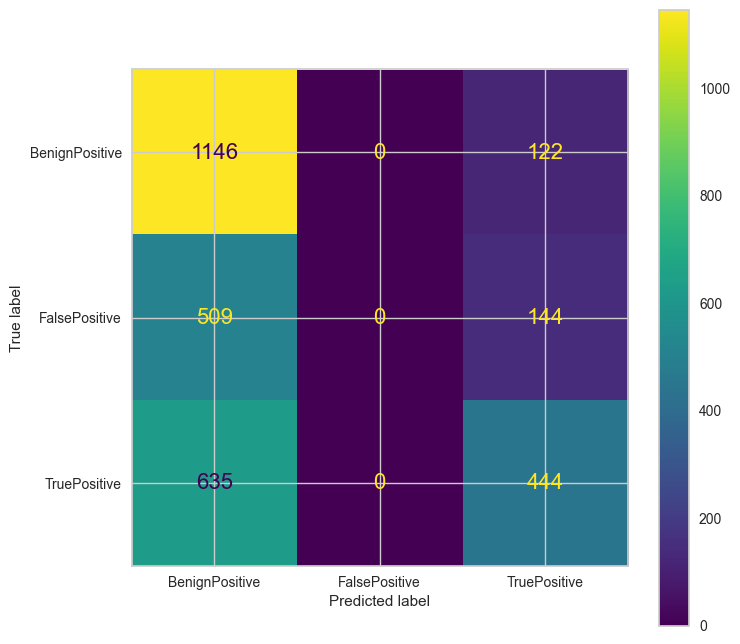

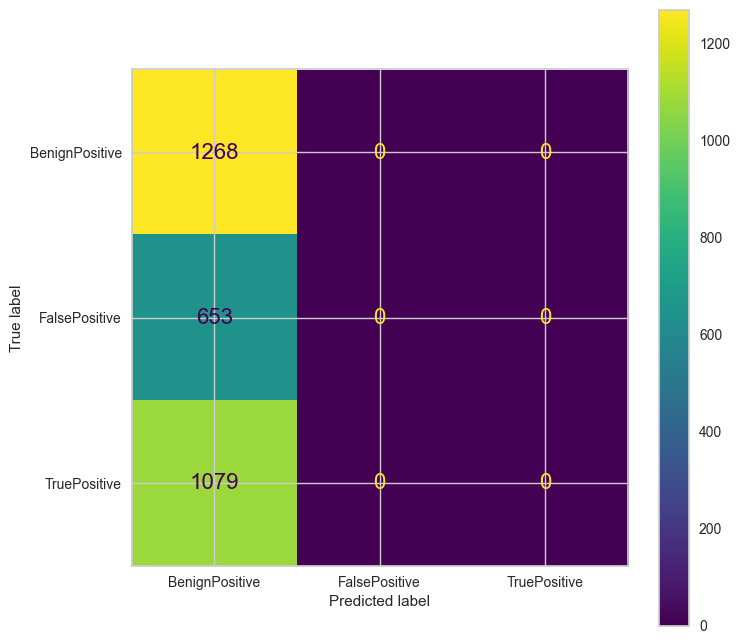

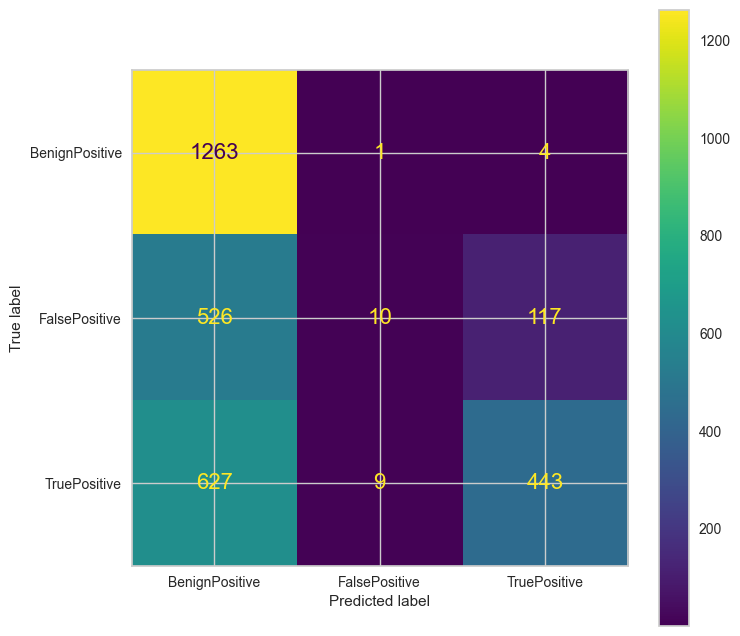

In [14]:
plt.figure(figsize=(8,8));
print('MultinomialNB')
ConfusionMatrixDisplay.from_estimator(mnb_model, X_test,y_test, display_labels=target_names, ax=plt.subplot());
plt.figure(figsize=(8,8));
print('GaussianNB')
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, display_labels=target_names, ax=plt.subplot());
plt.figure(figsize=(8,8));
print('BernoulliNB')
ConfusionMatrixDisplay.from_estimator(bnb_model, X_test,y_test, display_labels=target_names, ax=plt.subplot());

#### Confusion Matrix:

- **GaussianNB:** It does a really bad job by classifying almost everything as `BenignPositive`.

- **BernoulliNB vs MultinomialNB:**
  - **BernoulliNB:** Does a bit better at classifying `FalsePositive`.
  - **MultinomialNB:** More balanced but still struggles with `FalsePositive`.

#### Conclusion:
- **BernoulliNB** is better at recognizing `FalsePositive`, while **GaussianNB** doesn't perform well overall.


In [15]:
## Save results
results_dfLinear = save_results(mnb_model, X_test, y_test, 'MNB', results_dfLinear)
results_dfLinear = save_results(gnb_model, X_test, y_test, 'GNB', results_dfLinear)
results_dfLinear = save_results(bnb_model, X_test, y_test, 'BNB', results_dfLinear)
results_dfLinear.sort_values('test acc', ascending=False)

,Cross-val acc,test acc,precision score (M),recall score (M),f1 score (M)
BNB,NaN,0.572,0.603,0.474,0.418
MNB,NaN,0.530,0.375,0.438,0.380
GNB,NaN,0.423,0.141,0.333,0.198


### Logistic Regression

We chose **Logistic Regression** because it is a simple and efficient model for binary and multiclass classification problems. It works well when the relationship between the input features and the target is linear. Additionally, it is easy to interpret and often performs well with smaller datasets. While it requires some tuning of hyperparameters (like regularization), it is a good baseline model to compare against more complex algorithms. Since it assumes a linear decision boundary, it might not perform as well with highly non-linear data.


In [16]:
lr = LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=cv, n_jobs=-1, refit=True)
lr_gs.fit(X_train, y_train); 

In [17]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.607,1
31,"{'C': 31.622776601683796, 'penalty': 'l2'}",0.607,2
39,"{'C': 501.1872336272725, 'penalty': 'l2'}",0.607,3
35,"{'C': 125.89254117941663, 'penalty': 'l2'}",0.607,4
25,"{'C': 3.9810717055349696, 'penalty': 'l2'}",0.607,5


In our exploration, we found that the best parameters for Logistic Regression are:
- **Penalty**: L2 (which is the regularization term to reduce overfitting by penalizing large coefficients).
- **C**: 1.99 (which is the inverse of regularization strength. A smaller value of C indicates stronger regularization, and a larger value means weaker regularization. A C of 1.99 means a moderate level of regularization).

These results suggest that a balance between underfitting and overfitting is achieved with the chosen parameters.


Let's visualizes the feature importance in the logistic regression model using a heatmap of the coefficient values.

Coefs:


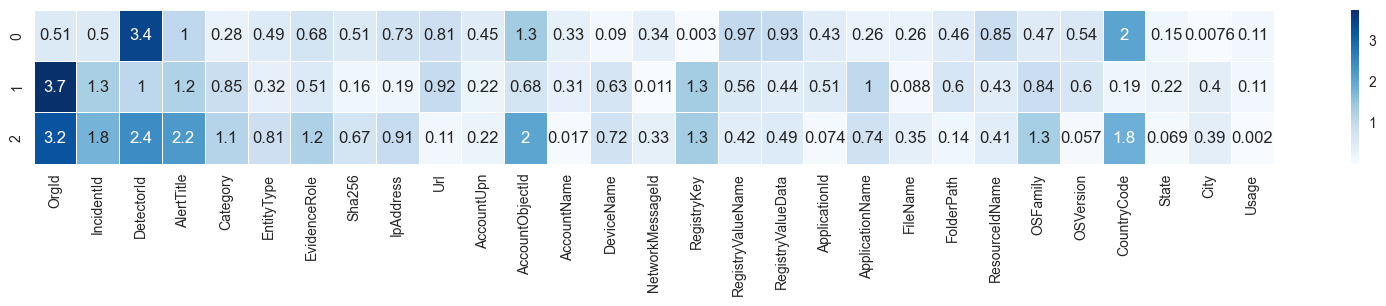

In [18]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

It seems that attributes like `originID`, `incidentID`, `detectorID`, and `alertTitle` are the most important. 

The first one, `originID`, might be relevant since it represents the organization identifier, which could have an impact on the incident's context. However, the other attributes are unique IDs, and we don’t see any clear relationship. The model may have assigned high importance to these features due to their strong correlation with certain outcomes in the dataset, but it's worth investigating further to understand why the model is prioritizing them.


In [19]:
print(classification_report(y_test, lr_gs.predict(X_test), target_names=target_names))
results_dfLinear = save_results(lr_gs, X_test, y_test, 'Logistic Regression', results_dfLinear)

                precision    recall  f1-score   support

BenignPositive       0.50      0.99      0.67      1268
 FalsePositive       0.79      0.03      0.06       653
  TruePositive       0.86      0.39      0.54      1079

      accuracy                           0.56      3000
     macro avg       0.72      0.47      0.42      3000
  weighted avg       0.70      0.56      0.49      3000



#### Logistic Regression Performance:

- **Accuracy**: 0.56.
- **Precision/Recall**: Logistic Regression shows decent performance for all classes, with high precision for **TruePositive** (0.86) but still lower recall for **FalsePositive** (0.03).
- **F1-Score**: The F1-scores are balanced with a moderate value for **TruePositive** (0.54).

#### Comparison with BernoulliNB (Best Naive Bayes Model):

- **Accuracy**: **BernoulliNB** has a slightly higher accuracy (0.57 vs 0.56).
- **Precision/Recall**: Logistic Regression balances precision and recall better across all classes. **BernoulliNB** performs well in recall for **BenignPositive**, but has very low recall for **FalsePositive** (0.02).

Naive Bayes BernoulliNB the best till now...

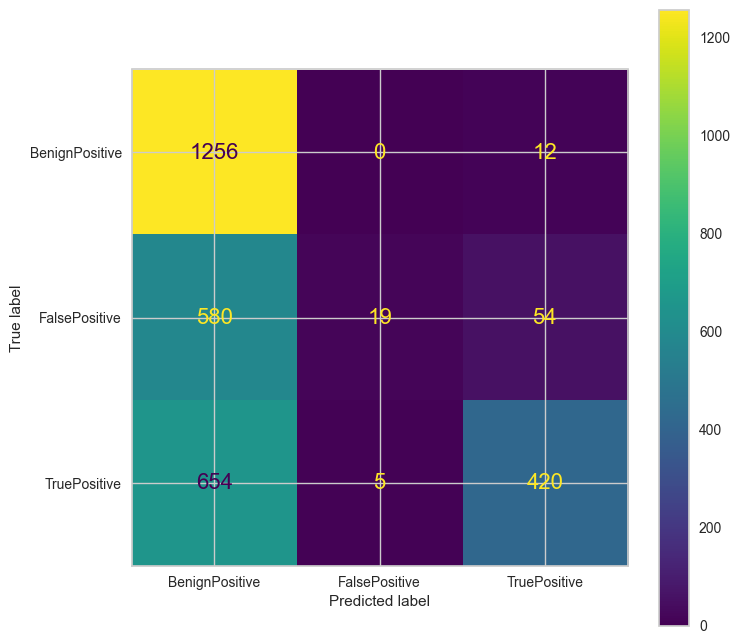

In [20]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,y_test, display_labels=target_names, ax=plt.subplot());

The slight decrease in accuracy is due to the misclassification of the **TruePositive** class, as shown in the confusion matrix.


Feature Importances (Absolute Coefficients):
                   BenignPositive  FalsePositive  TruePositive
OrgId                       0.509          3.726         3.218
IncidentId                  0.503          1.270         1.773
DetectorId                  3.432          1.036         2.396
AlertTitle                  1.017          1.194         2.211
Category                    0.275          0.855         1.130
EntityType                  0.487          0.321         0.808
EvidenceRole                0.681          0.514         1.195
Sha256                      0.511          0.161         0.672
IpAddress                   0.726          0.188         0.914
Url                         0.814          0.923         0.109
AccountUpn                  0.446          0.224         0.223
AccountObjectId             1.341          0.682         2.023
AccountName                 0.326          0.308         0.017
DeviceName                  0.090          0.632         0.722
NetworkMe

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Absolute Coefficient Value')

Text(0.5, 1.0, 'Feature Importances for Each Class in Logistic Regression')

<Figure size 1200x800 with 0 Axes>

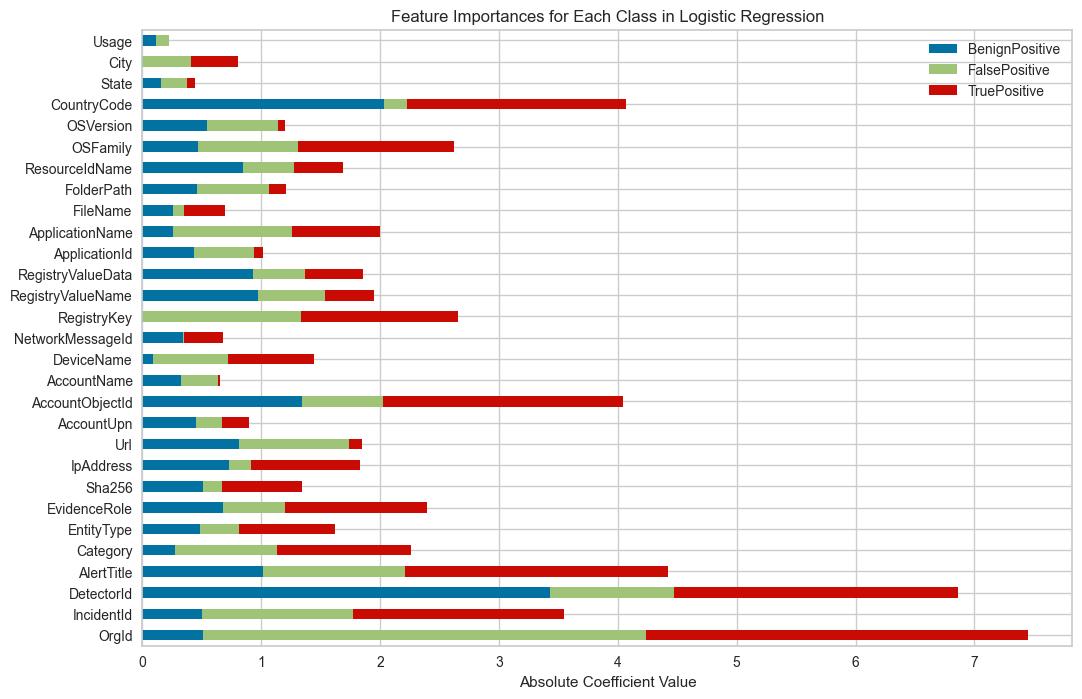

In [21]:
coef = lr_gs.best_estimator_.coef_  
feature_importance = pd.DataFrame(coef.T, index=X_train.columns, columns=target_names)
feature_importance_abs = feature_importance.abs()
print("\nFeature Importances (Absolute Coefficients):")
print(feature_importance_abs)

plt.figure(figsize=(12, 8))
feature_importance_abs.plot(kind='barh', stacked=True, figsize=(12, 8))
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importances for Each Class in Logistic Regression')
plt.show()

In the previous graph, we can see the relevance of each attribute for each class. Most attributes show significantly higher importance for the **True Positive** class compared to the others.


Feature Importances (Permutation) for Logistic Regression:
                   importance
CountryCode         7.647e-02
AccountObjectId     2.507e-02
IncidentId          1.987e-02
EntityType          1.847e-02
AccountName         1.607e-02
IpAddress           1.407e-02
EvidenceRole        1.307e-02
OrgId               9.467e-03
FileName            6.867e-03
NetworkMessageId    6.400e-03
FolderPath          5.867e-03
Sha256              5.733e-03
Category            5.733e-03
AlertTitle          5.133e-03
DeviceName          4.600e-03
DetectorId          4.400e-03
Url                 4.267e-03
RegistryKey         1.600e-03
OSVersion           1.267e-03
OSFamily            7.333e-04
State               4.000e-04
RegistryValueData   2.000e-04
RegistryValueName   2.000e-04
ResourceIdName      0.000e+00
Usage              -1.333e-04
ApplicationName    -1.333e-04
ApplicationId      -4.667e-04
City               -2.200e-03
AccountUpn         -1.127e-02


<Figure size 1200x800 with 0 Axes>

<BarContainer object of 29 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from Logistic Regression (Permutation Importance)')

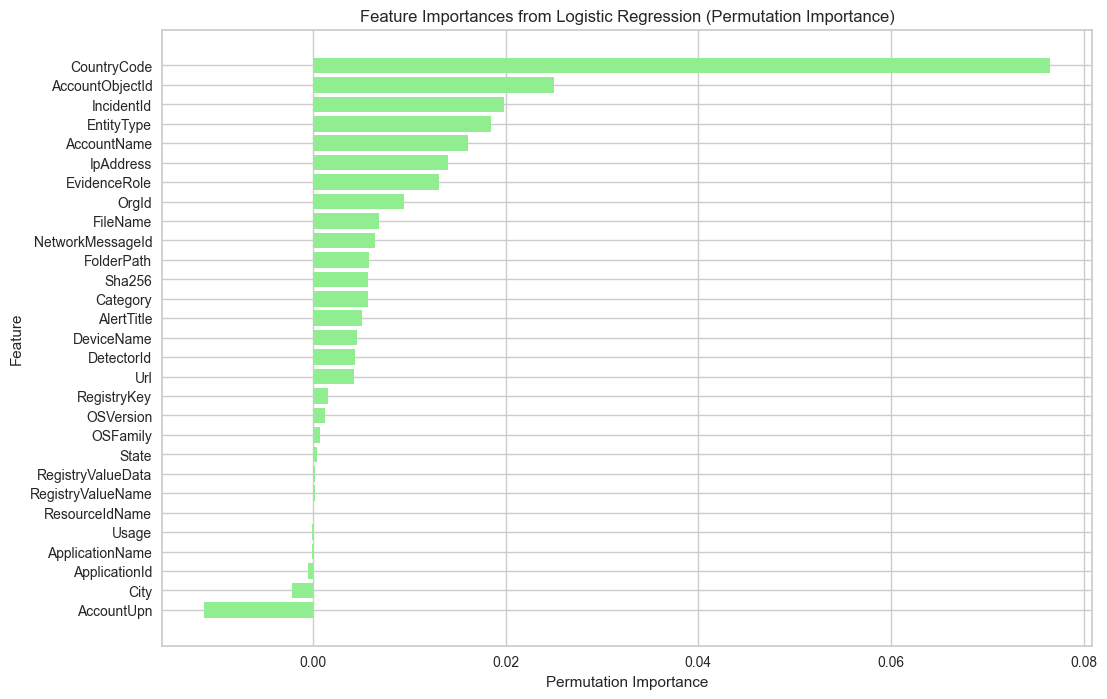

In [22]:
pi = permutation_importance(lr_gs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)
feature_importance_lr = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_lr = feature_importance_lr.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for Logistic Regression:")
print(feature_importance_lr)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_lr.index, feature_importance_lr["importance"], color="lightgreen")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Logistic Regression (Permutation Importance)")
plt.show()

**Permutation Importance Explanation:**

Permutation importance shows how much a feature affects model performance when shuffled. Higher importance means greater impact.

- **Most Important Features**: 
  - **CountryCode**: 0.0764
  - **AccountObjectId**: 0.0251
  - **IncidentId**: 0.0199

- **Least Important Features**:
  - **ApplicationId**: -0.000467
  - **Usage**: -0.000133
  - **ResourceIdName**: 0.0
  
The features with higher importance, such as **CountryCode**, **AccountObjectId**, and **IncidentId**, are likely more informative for the model in distinguishing between the classes. On the other hand, features like **ResourceIdName** and **ApplicationId** have lower importance, possibly because they contribute less to the decision-making process or have less variability in relation to the target variable.


### K-nearest Neighbours (KNN)

K-nearest Neighbours (KNN) is a simple and intuitive classification algorithm that works by finding the 'k' nearest data points to a given test point and classifying it based on the majority class of those neighbors. It is chosen for its ease of implementation and effectiveness when data is well-behaved, especially in smaller datasets. However, KNN can struggle with large datasets or when features have varying scales, as it is sensitive to the distance metric used. Remember that KNN need the data to be scaled, but we have already done that in the preprocessing step in the **DataPreparation** notebook.


In [23]:
knn =  KNeighborsClassifier()
param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 17, 19, 21],
          'weights':['distance', 'uniform'],
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs.fit(X_train, y_train);

In [24]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
30,"{'metric': 'l1', 'n_neighbors': 17, 'weights': 'distance'}",0.720,1
28,"{'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.720,2
32,"{'metric': 'l1', 'n_neighbors': 19, 'weights': 'distance'}",0.719,3
26,"{'metric': 'l1', 'n_neighbors': 11, 'weights': 'distance'}",0.718,4
34,"{'metric': 'l1', 'n_neighbors': 21, 'weights': 'distance'}",0.716,5


We see that the top 4 models (with a score of 0.713) have 15 or more neighbors, use weighted distance, and employ the L1 metric.

In KNN, increasing the number of neighbors (`n_neighbors`) increases computation time. If multiple models have the same performance but differ in neighbors, we choose the one with fewer neighbors to reduce computational cost.


In [25]:
print(classification_report(y_test, knn_gs.predict(X_test), target_names=target_names))
results_dfLinear= save_results(knn_gs, X_test, y_test, 'KNN', results_dfLinear)

                precision    recall  f1-score   support

BenignPositive       0.65      0.82      0.72      1268
 FalsePositive       0.63      0.43      0.51       653
  TruePositive       0.78      0.68      0.73      1079

      accuracy                           0.69      3000
     macro avg       0.69      0.64      0.65      3000
  weighted avg       0.69      0.69      0.68      3000



#### K-Nearest Neighbors Results:

- **Accuracy**: 0.69, better than both **Logistic Regression** (0.56) and **BernoulliNB** (0.57).
- **Precision/Recall**:
  - **BenignPositive**: High precision (0.63) and recall (0.83), good at identifying this class.
  - **FalsePositive**: Precision of 0.64, recall of 0.40, some difficulty distinguishing this class.
  - **TruePositive**: Precision 0.78, recall 0.67, decent performance.

#### Comparison with Previous Models:

- **Accuracy**: KNN outperforms **Logistic Regression** (0.56) and **BernoulliNB** (0.57).
- **Precision/Recall**: KNN has better recall for **FalsePositive** (0.43) than **Logistic Regression** (0.03), but lower precision for **TruePositive** (0.78 vs 0.86).
- **F1-Score**: KNN performs better in most metrics compared to **Logistic Regression** and **BernoulliNB**.

In conclusion, KNN offers a more balanced performance with better recall for **FalsePositive** and higher accuracy.


Podemos ver también cierto desbalance en sus predicciones

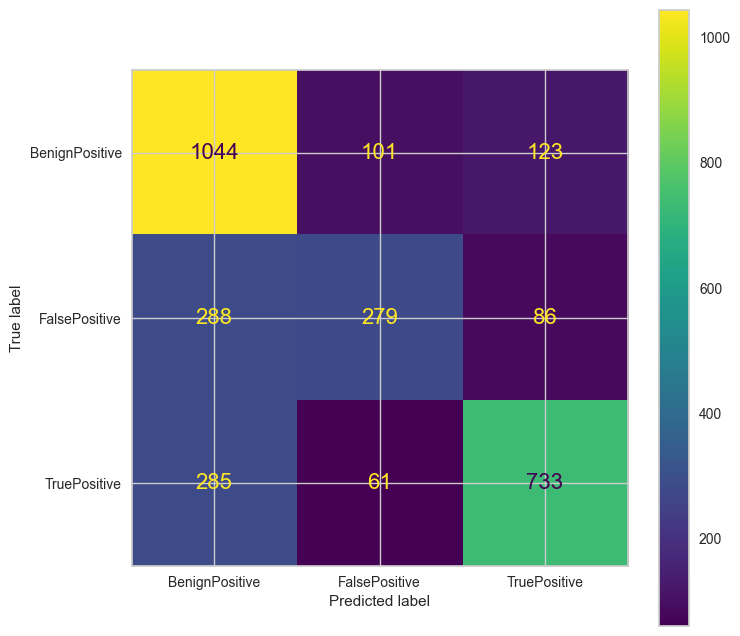

In [26]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test,y_test, display_labels=target_names, ax=plt.subplot());

The confusion matrix looks much better, especially for the **FalsePositive** class!

In [27]:
results_dfLinear.sort_values(by=['test acc'], ascending=False)

,Cross-val acc,test acc,precision score (M),recall score (M),f1 score (M)
KNN,0.720,0.685,0.685,0.643,0.653
BNB,NaN,0.572,0.603,0.474,0.418
Logistic Regression,0.607,0.565,0.720,0.470,0.420
MNB,NaN,0.530,0.375,0.438,0.380
GNB,NaN,0.423,0.141,0.333,0.198


#### Model Performance Summary

- **KNN**: KNN has the highest cross-validation accuracy (0.720) and test accuracy (0.685). It also performs well in precision, recall, and F1 score, making it the best overall model for this dataset. KNN strikes a good balance in detecting both positive and negative cases.

- **BNB (Bernoulli Naive Bayes)**: This model performs moderately well, with a test accuracy of 0.572. Its precision score is decent (0.603), but it struggles with recall (0.474) and F1 score (0.418), indicating it misses many positive instances, making it less reliable.

- **Logistic Regression**: Although Logistic Regression has the highest precision (0.720), its recall (0.470) and F1 score (0.420) are lower, meaning it struggles to detect positive cases. Its test accuracy of 0.565 suggests it's not the best performer overall.

- **MNB (Multinomial Naive Bayes)**: MNB has the lowest test accuracy (0.530) and shows poor performance in precision (0.375), recall (0.438), and F1 score (0.380). This indicates it is not effective for this classification task.

- **GNB (Gaussian Naive Bayes)**: GNB performs the worst, with a very low test accuracy (0.423) and extremely poor precision (0.141), recall (0.333), and F1 score (0.198). This model fails to classify data correctly and should not be used for this problem.




Feature Importances (Permutation) for KNN:
                   importance
EvidenceRole        7.780e-02
IncidentId          7.273e-02
EntityType          7.040e-02
IpAddress           5.907e-02
Category            5.427e-02
AccountObjectId     3.020e-02
DeviceName          1.900e-02
CountryCode         1.753e-02
NetworkMessageId    1.553e-02
Usage               7.333e-03
FileName            6.333e-03
AccountUpn          5.933e-03
DetectorId          5.867e-03
OrgId               5.667e-03
AlertTitle          4.667e-03
FolderPath          4.267e-03
Sha256              2.667e-03
OSFamily            2.333e-03
OSVersion           2.333e-03
RegistryKey         1.667e-03
ApplicationId       1.133e-03
ApplicationName     1.000e-03
City                7.333e-04
RegistryValueData   3.333e-04
RegistryValueName   3.333e-04
State               2.000e-04
AccountName         6.667e-05
ResourceIdName      0.000e+00
Url                -3.333e-04


<Figure size 1200x800 with 0 Axes>

<BarContainer object of 29 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from KNN (Permutation Importance)')

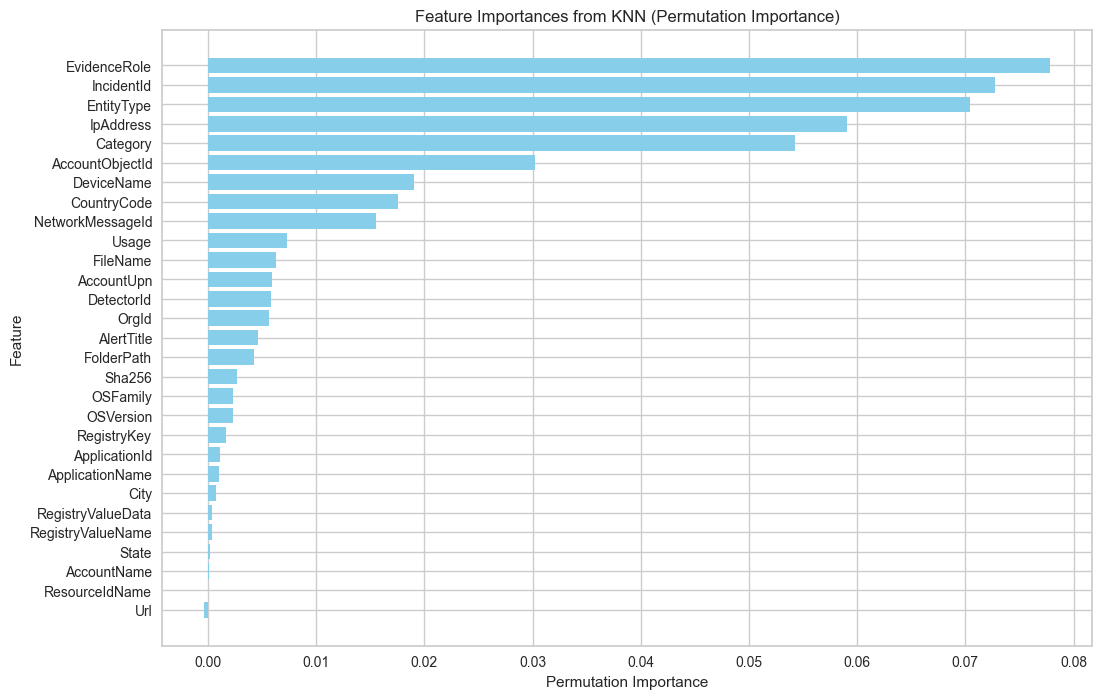

In [28]:
pi = permutation_importance(knn_gs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)

feature_importance_knn = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_knn = feature_importance_knn.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for KNN:")
print(feature_importance_knn)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_knn.index, feature_importance_knn["importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from KNN (Permutation Importance)")
plt.show()



1. **Most Important**: 
   - **IncidentId**  and **EntityType** are the top features that strongly influence the model.
   - **EvidenceRole** and **Category** are also significant.

2. **Moderately Important**:
   - **IpAddress** and **AccountObjectId** contribute but less so than the top features.

3. **Least Important**:
   - **ResourceIdName** and **City**  have very low or negative importance, showing they don't help much.

The model relies heavily on **IncidentId**, **EntityType**, and **EvidenceRole**, while other features like **ResourceIdName** contribute little.


### Conclusion: Linear/Quadratic Models



- **KNN**: Best overall performance with high precision, recall, and F1 score. Accuracy: 0.69.
- **Logistic Regression**: Good precision for `BenignPositive` (0.50), but very low recall for `FalsePositive` (0.03). Accuracy: 0.56.
- **BernoulliNB**: Strong for `BenignPositive` but weak for `FalsePositive` (precision 0.50, recall 0.02). Accuracy: 0.57.
- **MultinomialNB**: Low precision for `FalsePositive` (0.00) and poor recall. Accuracy: 0.53.
- **GaussianNB**: Worst performance with 0.00 precision and recall for `FalsePositive` and `TruePositive`. Accuracy: 0.42.

### Conclusion:
**KNN** is the best model, outperforming others in all metrics.


# Non Linear Models

### Random Forest

Random Forest builds multiple decision trees using random subsets of data and features, combining their outputs for predictions. It reduces overfitting and captures complex relationships, making it suitable for this problem. It also highlights feature importance, aiding in understanding key predictors.


In [29]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
         'criterion':['gini', 'entropy'],
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}
iter = 40
rf =  RandomForestClassifier(random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)

In [30]:
rf_bs.fit(X_train, y_train);

In [31]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
24,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}",0.831,1
22,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 75}",0.828,2
21,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}",0.828,3
13,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}",0.824,4
18,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 75}",0.824,5


After exploring the hyperparameters, similar to the previous linear models, we observe that the top performing combinations yield fairly consistent scores.

For the Random Forest model, 4 out of the top 5 configurations use `criterion` set to `entropy`, which indicates the model prefers using information gain over Gini impurity. Interestingly, none of the configurations specify a `max_depth`, suggesting that the model is benefiting from an unrestricted depth, allowing it to better capture complex patterns. Additionally, all the best combinations set `min_samples_leaf` to 1, meaning that leaf nodes are not required to have a minimum number of samples, which may help the model achieve more granular splits (but maybe some overfitting could happen). The most notable observation is that the top two combinations both use `n_estimators` set to 200, emphasizing that a higher number of trees contributes to better performance.


In [32]:
print(classification_report(y_test, rf_bs.predict(X_test), target_names=target_names))
results_dfNonLinear = save_results(rf_bs, X_test, y_test, 'Random Forest', results_dfNonLinear)

                precision    recall  f1-score   support

BenignPositive       0.77      0.93      0.84      1268
 FalsePositive       0.86      0.64      0.74       653
  TruePositive       0.89      0.81      0.85      1079

      accuracy                           0.82      3000
     macro avg       0.84      0.79      0.81      3000
  weighted avg       0.83      0.82      0.82      3000




- **BenignPositive**: High recall (0.93) and solid precision (0.77), with an F1-score of 0.84.
- **FalsePositive**: Good precision (0.86), moderate recall (0.64), and an F1-score of 0.74.
- **TruePositive**: High precision (0.89) and decent recall (0.81), with an F1-score of 0.85.
- **Accuracy**: 0.82, showing strong overall performance.
- **Macro avg**: 0.81, **Weighted avg**: 0.82, reflecting good balance across classes.

#### Comparison with KNN (Best Results So Far):

- **Accuracy**: Random Forest (0.82) outperforms KNN (0.68).
- **Precision**: RF is higher in **BenignPositive** (0.77 vs. 0.63) and **TruePositive** (0.89 vs. 0.78).
- **Recall**: RF has better recall for **BenignPositive** (0.93 vs. 0.83) and **FalsePositive** (0.64 vs. 0.40).
- **F1-Score**: RF leads in **BenignPositive** (0.84 vs. 0.72) and **TruePositive** (0.85 vs. 0.72).

Overall, **Random Forest** outperforms **KNN** in accuracy, precision, recall, and F1-score.


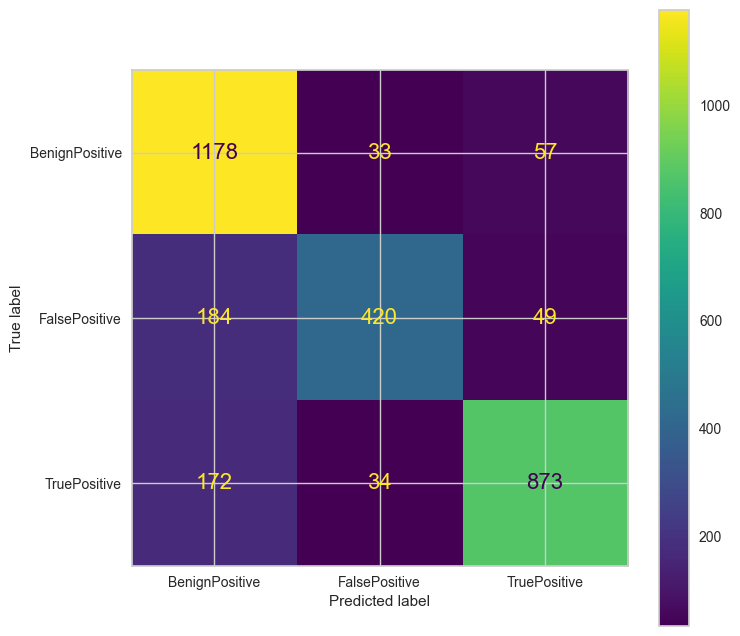

In [33]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rf_bs, X_test,y_test, ax=plt.subplot());


We observe a much better confusion matrix compared to the linear models! The class that is misclassified the most is **FalsePositive**. This could be due to its lower proportion in the dataset, which makes it harder for the model to accurately classify, leading to lower recall for this class.

However, the model still performs well overall, with high accuracy for **BenignPositive** and **TruePositive**. The imbalance in the dataset might be influencing the classification of the **FalsePositive** class.


In [34]:
importances = pd.DataFrame(rf_bs.best_estimator_.feature_importances_)


Feature Importances (Permutation) for Random Forest:
                   importance
IncidentId          1.235e-01
OrgId               9.767e-02
DetectorId          7.933e-02
AlertTitle          5.053e-02
Category            3.067e-02
Usage               8.333e-03
IpAddress           7.467e-03
EntityType          5.267e-03
NetworkMessageId    4.600e-03
CountryCode         4.467e-03
AccountUpn          3.933e-03
DeviceName          3.667e-03
AccountObjectId     3.667e-03
EvidenceRole        3.267e-03
FolderPath          2.933e-03
FileName            1.933e-03
AccountName         1.133e-03
OSFamily            5.333e-04
OSVersion           4.000e-04
Sha256              3.333e-04
ApplicationName     3.333e-04
ResourceIdName      0.000e+00
RegistryValueData   0.000e+00
RegistryKey         0.000e+00
RegistryValueName   0.000e+00
ApplicationId      -1.333e-04
Url                -4.667e-04
State              -6.667e-04
City               -1.267e-03


<Figure size 1200x800 with 0 Axes>

<BarContainer object of 29 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from Random Forest (Permutation Importance)')

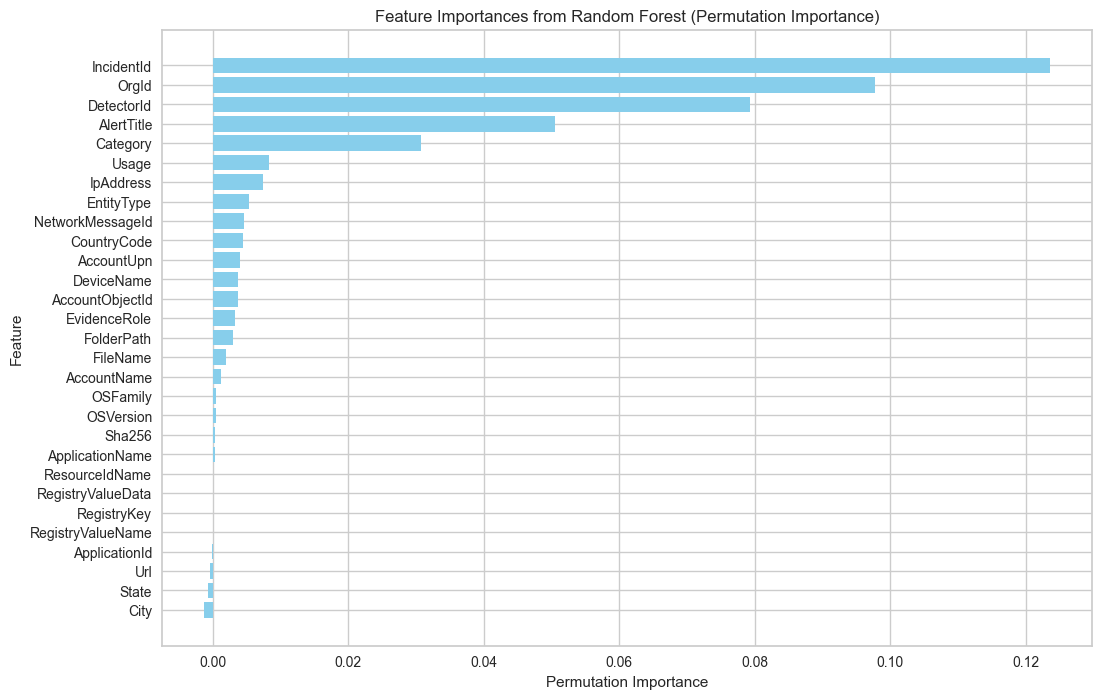

In [35]:
pi = permutation_importance(rf_bs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)

feature_importance_rf = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_rf = feature_importance_rf.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for Random Forest:")
print(feature_importance_rf)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_rf.index, feature_importance_rf["importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Random Forest (Permutation Importance)")
plt.show()

- **Most Important Features**:
  - **IncidentId**: 12.35%
  - **OrgId**: 9.77%
  - **DetectorId**: 7.93%

- **Less Important Features**:
  - **ApplicationId**: -0.13%
  - **Url**: -0.47%
  - **State**: -0.67%

- **Zero Importance**:
  - **ResourceIdName**, **RegistryValueData**, **RegistryKey**, **RegistryValueName**

We can observe a significant similarity between the most important features in this model and the ones identified by linear models using permutation importance. **IncidentId** and **OrgId** appear as key features in both models, highlighting their relevance in this classification task.


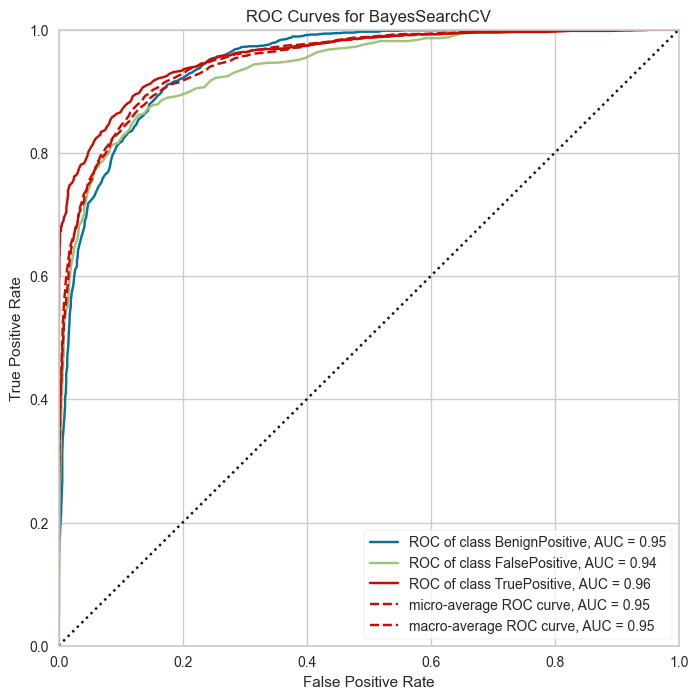

In [36]:
plt.figure(figsize=(8,8));
roc_auc(rf_bs, X_train, y_train, X_test, y_test, classes=target_names);

(theory):The ROC curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)**, showing how well a model distinguishes between classes. A good model has a curve that bends towards the top-left, indicating high TPR and low FPR.

The ROC scores for each class are approximately **0.95**, which indicates excellent performance by the model. 

A ROC score close to 1 means that the model is very effective at distinguishing between the positive and negative classes. Specifically:

- **0.95 ROC score** suggests that for each class (BenignPositive, FalsePositive, TruePositive), the model has a high true positive rate and a low false positive rate.
- This is indicative of a model with good discrimination ability and low error in classifying the instances correctly.


### SVM with RBF Kernel

SVM with RBF kernel is a method that helps classify complex data that can't be separated by a straight line. It transforms the data into a higher dimension where it becomes easier to separate the classes.

It calculates the similarity between points in this new space to find a clear boundary.

Great for non-linear data where a straight line won't work.


In [37]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto'], 'probability': [True]}

rbsvc =  SVC(kernel='rbf', max_iter=25000, random_state=0)
rbsvc_gs = BayesSearchCV(rbsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)

In [38]:
rbsvc_gs.fit(X_train, y_train);

In [39]:
show_html(pd.DataFrame(rbsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'C': 758.5775750291835, 'gamma': 'scale', 'probability': True}",0.673,1
10,"{'C': 660.6934480075951, 'gamma': 'scale', 'probability': True}",0.671,2
11,"{'C': 109.64781961431851, 'gamma': 'scale', 'probability': True}",0.668,3
14,"{'C': 758.5775750291835, 'gamma': 'auto', 'probability': True}",0.660,4
6,"{'C': 660.6934480075951, 'gamma': 'auto', 'probability': True}",0.659,5



After exploring the hyperparameters, we found that the best combination is with **C = 660.69**, **gamma = scale**, and **probability = true**. Among the top-performing combinations, **gamma = scale** was common, and all used **probability = true**. 


In [40]:
print(classification_report(y_test, rbsvc_gs.predict(X_test), target_names=target_names))
results_dfNonLinear = save_results(rbsvc_gs, X_test, y_test, 'RBF SVM binary', results_dfNonLinear)

                precision    recall  f1-score   support

BenignPositive       0.53      0.94      0.68      1268
 FalsePositive       0.81      0.02      0.04       653
  TruePositive       0.83      0.57      0.67      1079

      accuracy                           0.60      3000
     macro avg       0.72      0.51      0.46      3000
  weighted avg       0.70      0.60      0.54      3000




- **BenignPositive**: High recall (0.94) but low precision (0.50), indicating frequent misclassifications of negatives as positives.  
- **FalsePositive**: Extremely poor recall (0.02) and F1-score (0.04), showing it barely detects this class.  
- **TruePositive**: Moderate precision (0.81) but low recall (0.46), missing many true positives.  

- **Accuracy**: 0.57, much lower than RF.  
- **Macro F1**: 0.43, reflecting poor balance across classes.  
- **Weighted F1**: 0.50, heavily influenced by the largest class.

#### Comparison with Random Forest (RF)

RF significantly outperforms SVM, with better accuracy (0.82) and balanced class performance. While SVM slightly improves recall for **BenignPositive**, it sacrifices precision and struggles to detect **FalsePositive**, making RF the superior model.


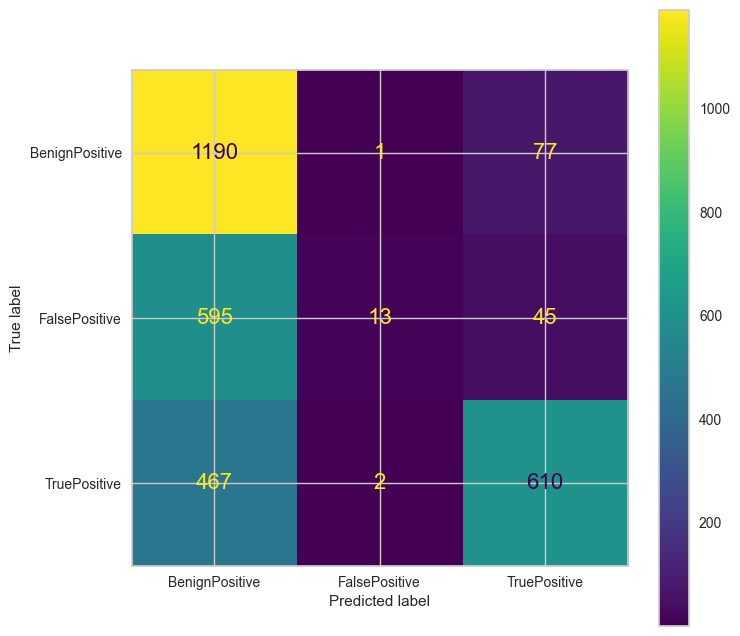

In [41]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbsvc_gs, X_test, y_test, display_labels=target_names, ax=plt.subplot());

As observed in the confusion matrix, the SVM model performs terribly for the **FalsePositive** class, with almost no true detections (recall of 0.02). Its performance is reminiscent of simpler models like Naive Bayes or Logistic Regression, as it struggles to balance class predictions and provide meaningful classification for minority classes. Overall, this highlights SVM's limitations for this specific problem compared to more robust models like Random Forest.


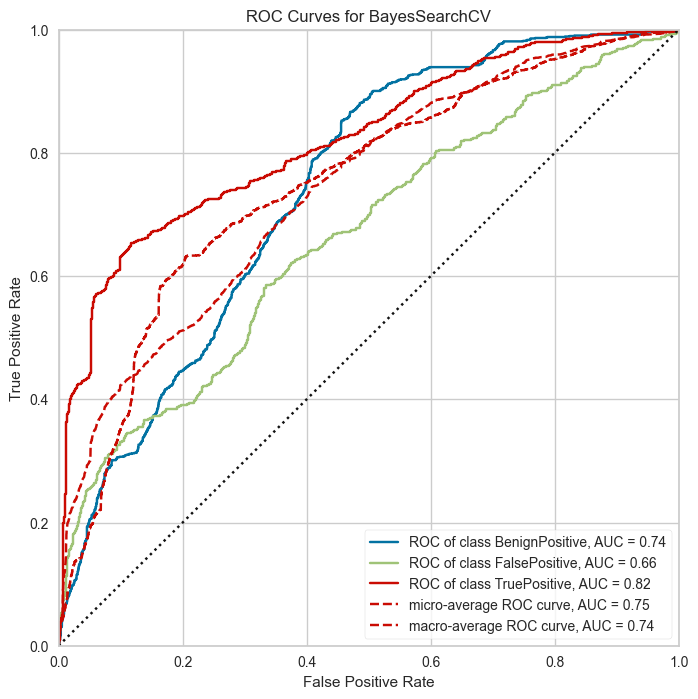

In [42]:
plt.figure(figsize=(8,8));
roc_auc(rbsvc_gs, X_train, y_train, X_test, y_test, classes=target_names);

The ROC values for the SVM model are notably lower compared to Random Forest, indicating weaker performance in distinguishing between classes. Specifically:

- **FalsePositive**: 0.66, showing very poor discrimination for this class.
- **TruePositive**: 0.82, the highest ROC value, but still below the performance of Random Forest.
- **BenignPositive**: 0.74, reflecting moderate ability to differentiate this class.

These results emphasize that SVM struggles to capture the complexity of the dataset as effectively as Random Forest, especially for minority or challenging classes like **FalsePositive**.



Feature Importances (Permutation) for SVM with RBF Kernel:
                   importance
EntityType          9.733e-02
AccountName         6.673e-02
AccountObjectId     5.647e-02
CountryCode         5.340e-02
AccountUpn          4.567e-02
IncidentId          3.953e-02
FileName            3.853e-02
State               3.113e-02
EvidenceRole        2.687e-02
Sha256              2.180e-02
IpAddress           1.353e-02
Category            1.320e-02
FolderPath          1.067e-02
AlertTitle          1.000e-02
NetworkMessageId    7.667e-03
City                6.467e-03
OSVersion           5.467e-03
OSFamily            5.067e-03
DetectorId          3.133e-03
DeviceName          2.400e-03
OrgId               2.067e-03
ApplicationId       2.667e-04
RegistryValueName   2.000e-04
ApplicationName     2.000e-04
RegistryKey         1.333e-04
ResourceIdName      0.000e+00
Url                -4.667e-04
RegistryValueData  -4.667e-04
Usage              -2.800e-03


<Figure size 1200x800 with 0 Axes>

<BarContainer object of 29 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from SVM with RBF Kernel (Permutation Importance)')

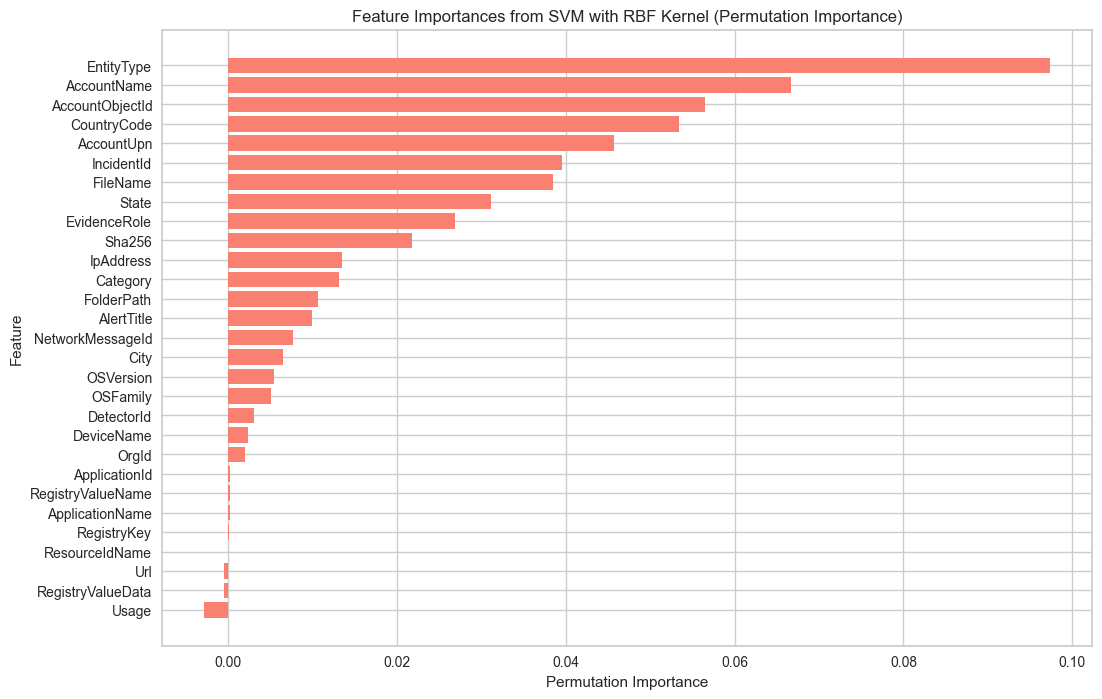

In [43]:
pi = permutation_importance(rbsvc_gs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)

feature_importance_svm_rbf = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_svm_rbf = feature_importance_svm_rbf.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for SVM with RBF Kernel:")
print(feature_importance_svm_rbf)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_svm_rbf.index, feature_importance_svm_rbf["importance"], color="salmon")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from SVM with RBF Kernel (Permutation Importance)")
plt.show()

The most important features identified by the SVM model are quite different from those highlighted by other models, such as Random Forest and Logistic Regression. Key features like **EntityType**, **AccountName**, and **CountryCode** rank high here but were not as prominent in previous models. Similarly, features like **IncidentId** and **OrgId**, which were highly influential in other models, have lower importance in this case.

This discrepancy suggests that the SVM model may not effectively capture the patterns in the data for this problem, further reinforcing the observation that it underperforms compared to Random Forest.


### Gradient Boosting

Gradient Boosting is a technique that builds models step by step, where each step focuses on correcting the errors of the previous one. It combines many small decision trees to create a more accurate model. 

This approach can be useful here as it is designed to handle complex relationships in the data and improve performance incrementally.


In [44]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
         'loss':['log_loss'], 
         'criterion':['friedman_mse', 'squared_error'],
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10],
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}
iter = 40
gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)

In [45]:
gb_bs.fit(X_train, y_train);

In [46]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
33,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}",0.866,1
36,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 200}",0.864,2
34,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}",0.863,3
35,"{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}",0.861,4
38,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200}",0.859,5



After exploring the hyperparameters, we identified two top-performing combinations, differing only in `n_estimators` (50 vs. 75). Both use:

- **Criterion (friedman_mse)**: Optimizes tree splits for better performance.  
- **Learning Rate (0.5)**: Balances the impact of each tree, controlling how much each step corrects errors.  
- **Loss (log_loss)**: Focuses on minimizing classification errors.  
- **Max Depth (None)**: Allows trees to grow without depth restrictions, capturing more complexity.  
- **Min Samples Leaf (10)**: Ensures each leaf node has at least 10 samples, avoiding overfitting.  
- **n_estimators (50/75)**: Number of trees in the ensemble, controlling model complexity and performance.



In [47]:
print(classification_report(y_test, gb_bs.predict(X_test), target_names=target_names))
results_dfNonLinear = save_results(gb_bs, X_test, y_test, 'Gradient Boosting', results_dfNonLinear)

                precision    recall  f1-score   support

BenignPositive       0.77      0.90      0.83      1268
 FalsePositive       0.79      0.64      0.71       653
  TruePositive       0.88      0.81      0.84      1079

      accuracy                           0.81      3000
     macro avg       0.81      0.78      0.79      3000
  weighted avg       0.81      0.81      0.81      3000




The Gradient Boosting model achieves an overall accuracy of **81%**, with balanced precision and recall across classes. Notably:

- **BenignPositive**: High recall (0.90) ensures most true positives are captured.  
- **FalsePositive**: Moderate performance (recall: 0.64), slightly below Random Forest.  
- **TruePositive**: Comparable f1-score (0.81) to Random Forest.

Both models deliver similar overall performance, but Random Forest shows slightly better recall for the FalsePositive class, making it marginally more robust for this problem.


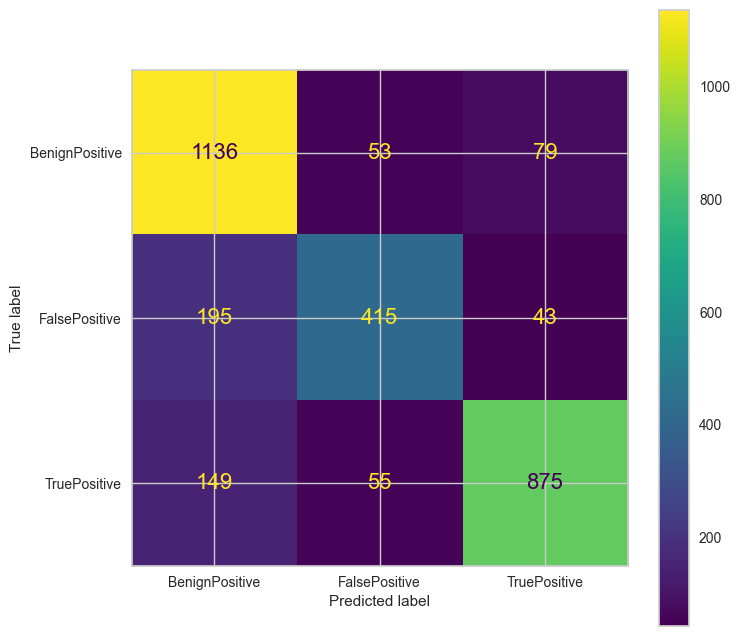

In [48]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gb_bs, X_test,y_test, ax=plt.subplot());

In the confusion matrix, compared to the best model so far (Random Forest), we observe a slight decline in the classification of the **BenignPositive** class. However, this is compensated by a slight improvement in the classification of the other two classes.

This could be beneficial, as the **BenignPositive** class has more instances, and improving the classification of the smaller classes (**FalsePositive** and **TruePositive**) could be more impactful for overall performance, especially if these minority classes are critical to detect more accurately.


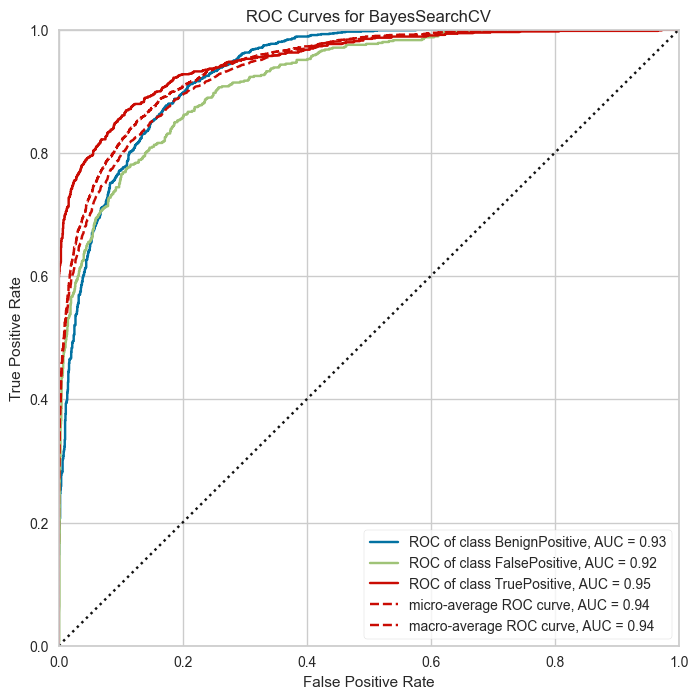

In [49]:
plt.figure(figsize=(8,8));
roc_auc(gb_bs, X_train, y_train, X_test, y_test, classes=target_names);

Once again, the ROC scores for the different classes are quite strong, all around 0.95. This indicates that the **Gradient Boosting** model is performing well in distinguishing between the classes, similar to the **Random Forest** model, which suggests it is a reliable option for this task.


Feature Importances (Permutation) for Gradient Boosting:
                   importance
OrgId               1.565e-01
IncidentId          1.356e-01
DetectorId          1.258e-01
AlertTitle          3.160e-02
Category            2.633e-02
Usage               8.333e-03
AccountUpn          6.333e-03
IpAddress           5.867e-03
Url                 5.067e-03
AccountObjectId     4.333e-03
CountryCode         3.000e-03
FileName            2.733e-03
DeviceName          1.733e-03
EntityType          1.467e-03
FolderPath          1.467e-03
Sha256              9.333e-04
EvidenceRole        7.333e-04
OSFamily            6.667e-04
ApplicationName     6.000e-04
State               4.667e-04
OSVersion           4.667e-04
NetworkMessageId    4.000e-04
City                2.667e-04
RegistryValueName   0.000e+00
RegistryValueData   0.000e+00
ResourceIdName      0.000e+00
RegistryKey        -1.333e-04
ApplicationId      -6.667e-04
AccountName        -1.800e-03


<Figure size 1200x800 with 0 Axes>

<BarContainer object of 29 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from Gradient Boosting (Permutation Importance)')

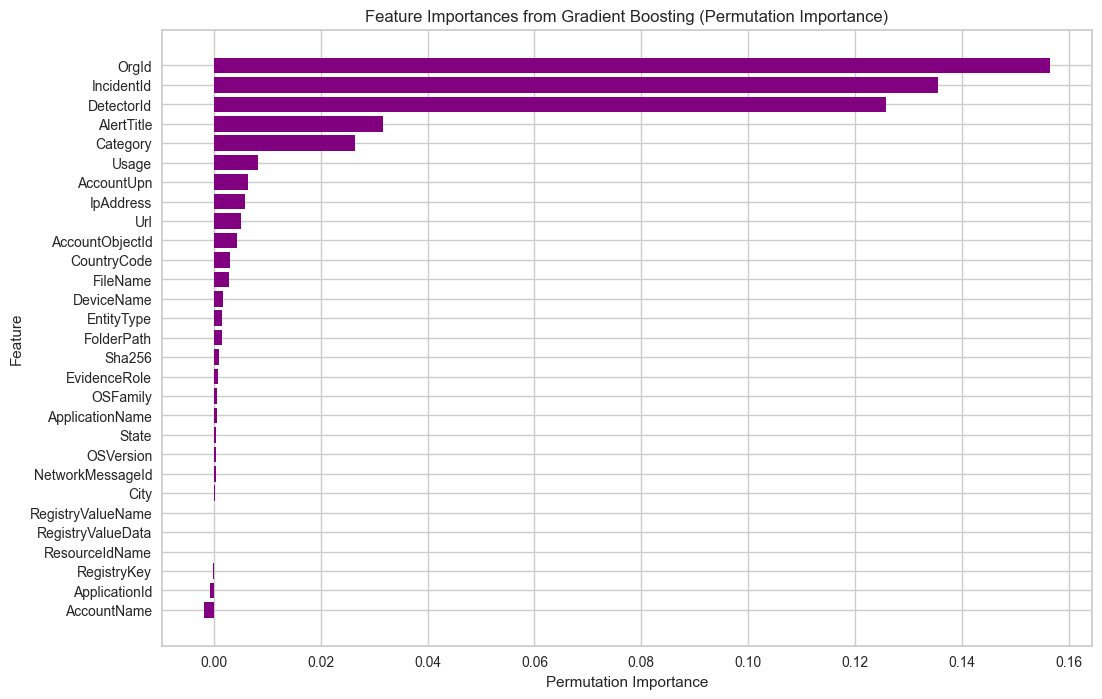

In [50]:
pi = permutation_importance(gb_bs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)

feature_importance_gb = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_gb = feature_importance_gb.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for Gradient Boosting:")
print(feature_importance_gb)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_gb.index, feature_importance_gb["importance"], color="purple")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Gradient Boosting (Permutation Importance)")
plt.show()

The most important features identified by **Gradient Boosting** are:

- **OrgId** 
- **IncidentId** 
- **DetectorId**
- **AlertTitle** 

These features, particularly `OrgId` and `IncidentId`, play a central role in classification. When compared to the features identified in earlier models like **Random Forest**, we see some overlap, especially with `IncidentId` and `AlertTitle`. However, models like **SVM** still prioritize different features, like `EntityType` and `AccountName`.

This difference in feature importance suggests that **SVM** might not be the best option for this problem, as its top features do not align with the more consistent and relevant features highlighted by **Random Forest** and **Gradient Boosting**. Therefore, **Gradient Boosting** appears to be more effective in utilizing the key attributes for classification in this case.


In [51]:
print('Linear Models')
results_dfLinear.sort_values(by=['test acc'], ascending=False)
print('Non Linear Models')
results_dfNonLinear.sort_values(by=['test acc'], ascending=False)

Linear Models


,Cross-val acc,test acc,precision score (M),recall score (M),f1 score (M)
KNN,0.720,0.685,0.685,0.643,0.653
BNB,NaN,0.572,0.603,0.474,0.418
Logistic Regression,0.607,0.565,0.720,0.470,0.420
MNB,NaN,0.530,0.375,0.438,0.380
GNB,NaN,0.423,0.141,0.333,0.198


Non Linear Models


,Cross-val acc,test acc,precision score (M),recall score (M),f1 score (M)
Random Forest,0.831,0.824,0.841,0.794,0.809
Gradient Boosting,0.866,0.809,0.813,0.781,0.792
RBF SVM binary,0.673,0.604,0.725,0.508,0.463


### Conclusion: Non-Linear Models

Among the non-linear models, **SVM** is not an ideal option due to its poor performance when classifying classes with fewer instances, as seen with the *FalsePositive* class. Additionally, the feature selection process of SVM differs significantly from that of more robust models like **Random Forest** and **Gradient Boosting**, suggesting it is not making the most of the data.

On the other hand, **Gradient Boosting** showed strong performance, particularly in better classifying classes with fewer examples, which is valuable. However, its computational cost tends to be high, which can be a limiting factor in large-scale scenarios.

Finally, **Random Forest** stands out as the most balanced option, providing solid performance with relatively low computational cost, making it the most suitable choice for this problem.


### Saving the Models

In [52]:
from joblib import dump, load

In [53]:
filepath = 'models/'
dump(gb_bs, filepath+'gradient_boosting_model.joblib')
dump(rbsvc_gs, filepath+'rbf_svm_model.joblib')
dump(rf_bs, filepath+'random_forest_model.joblib')
dump(knn_gs, filepath+'knn_model.joblib')
dump(lr_gs, filepath+'logistic_regression_model.joblib')
dump(mnb_model, filepath+'multinomial_nb_model.joblib')
dump(gnb_model, filepath+'gaussian_nb_model.joblib')
dump(bnb_model, filepath+'bernoulli_nb_model.joblib')
print(f"Execution time: {timedelta(seconds=time() - init_time)}")

['models/gradient_boosting_model.joblib']

['models/rbf_svm_model.joblib']

['models/random_forest_model.joblib']

['models/knn_model.joblib']

['models/logistic_regression_model.joblib']

['models/multinomial_nb_model.joblib']

['models/gaussian_nb_model.joblib']

['models/bernoulli_nb_model.joblib']

Execution time: 0:15:40.922871
